# Natural Language Processing

NLP is a field of study at the intersection of :

    1.Computer Science
    2.AI
    3.Linguistic

The goal is to process natural language by the computers to do some task.

Sentiment analysis is an application of NLP.

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
#import some necessary packages
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt 
import seaborn as sns
%matplotlib inline
import warnings
warnings.simplefilter('ignore')

## Data

Project: Sentiment Analysis on Movie Reviews
         Using Rotten Tomatoes dataset for natural language processing or Text  analytics.
This is a dataset for binary sentiment classification.

In [3]:
training_data_folder = '/content/drive/My Drive/Colab Notebooks/RNN/train.tsv'

In [4]:
df = pd.read_csv(training_data_folder, sep='\t') #let's read the training dataset

In [5]:
df.head()

,PhraseId,SentenceId,Phrase,Sentiment
0,1,1,A series of escapades demonstrating the adage ...,1
1,2,1,A series of escapades demonstrating the adage ...,2
2,3,1,A series,2
3,4,1,A,2
4,5,1,series,2


In [6]:
len(df)

156060

In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 156060 entries, 0 to 156059
Data columns (total 4 columns):
 #   Column      Non-Null Count   Dtype 
---  ------      --------------   ----- 
 0   PhraseId    156060 non-null  int64 
 1   SentenceId  156060 non-null  int64 
 2   Phrase      156060 non-null  object
 3   Sentiment   156060 non-null  int64 
dtypes: int64(3), object(1)
memory usage: 4.8+ MB


In [8]:
df.Sentiment.value_counts()

2    79582
3    32927
1    27273
4     9206
0     7072
Name: Sentiment, dtype: int64

In [9]:
#The sentiment labels are:

# 0 - negative; 1 - somewhat negative; 2 - neutral; 3 - somewhat positive; 4 - positive

In [10]:
# let us check the phrase of the first data of the dataset
df.iloc[0]['Phrase']

'A series of escapades demonstrating the adage that what is good for the goose is also good for the gander , some of which occasionally amuses but none of which amounts to much of a story .'

In [11]:
# let us check the phrase of the second data of the dataset
df.iloc[1]['Phrase']

'A series of escapades demonstrating the adage that what is good for the goose'

#  Exploratory Data Analysis

Let's plot it!

Let's see if our data has any null values.

In [12]:
df.isnull().sum()

PhraseId      0
SentenceId    0
Phrase        0
Sentiment     0
dtype: int64

In [13]:
df.isna().sum()

PhraseId      0
SentenceId    0
Phrase        0
Sentiment     0
dtype: int64

In [14]:
df['Length'] = df['Phrase'].apply(lambda x: len(str(x).split(' ')))

In [15]:
df.head()

,PhraseId,SentenceId,Phrase,Sentiment,Length
0,1,1,A series of escapades demonstrating the adage ...,1,37
1,2,1,A series of escapades demonstrating the adage ...,2,14
2,3,1,A series,2,2
3,4,1,A,2,1
4,5,1,series,2,1


In [16]:
df['Length'].unique()

array([37, 14,  2,  1, 12, 11, 10,  3,  7,  6,  5,  4, 23, 22, 20, 19, 18,
       15,  9,  8, 21, 26, 25, 16, 13, 17, 30, 28, 27, 24, 41, 40, 36, 29,
       31, 32, 34, 33, 42, 39, 38, 35, 43, 45, 44, 49, 48, 47, 46, 51, 50,
       52])

Let's check out for any pattern

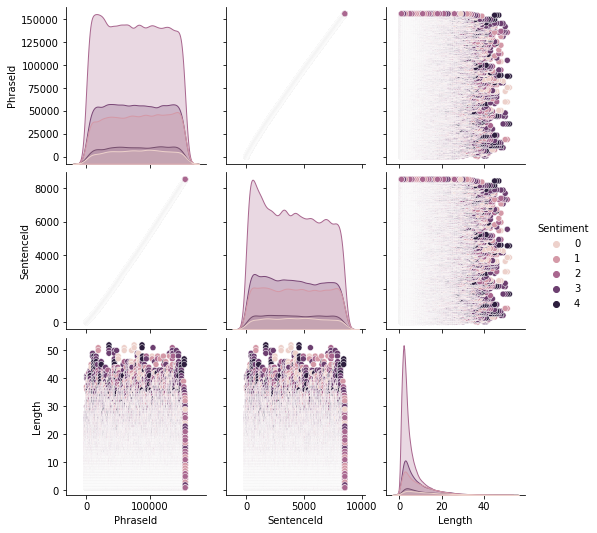

In [17]:
import seaborn as sns
sns.pairplot(df,hue='Sentiment',vars=['PhraseId','SentenceId','Length'])

In [18]:
#so sentiment 4 has short length reviews but also has long length reviews. But mainly sentiment 0,1 and 2 have longer length reviews. 
#Classifying on basis of length seems difficult.
#let's move on to next analysis

In [19]:
pwd

'/content'

In [20]:
import os

In [21]:
os.chdir("/content/drive/My Drive/Colab Notebooks")

In [22]:
pwd

'/content/drive/My Drive/Colab Notebooks'

In [23]:
#### !wget http://nlp.stanford.edu/data/glove.6B.zip

In [24]:
"""
import zipfile
zip_ref = zipfile.ZipFile('glove.6B.zip', 'r')
zip_ref.extractall('./')
zip_ref.close()

"""

"\nimport zipfile\nzip_ref = zipfile.ZipFile('glove.6B.zip', 'r')\nzip_ref.extractall('./')\nzip_ref.close()\n\n"

In [25]:
import gc
gc.collect()

141

In [76]:
import pandas as pd
import numpy as np
import os
import seaborn as sns
import pickle
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.utils.np_utils import to_categorical
from keras.models import Sequential, load_model
from keras.layers import Embedding, Dropout, Dense, LSTM
from keras.callbacks import CSVLogger, History, ModelCheckpoint, EarlyStopping
from keras import losses
from keras import activations
from keras import optimizers
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score, roc_curve, auc, accuracy_score, precision_recall_fscore_support, confusion_matrix
%matplotlib inline

class RottenTomatoesLSTM(object):
    def __init__(self, parms):
        self._parms = parms
        self._tokenizer = Tokenizer(num_words=self._parms['vocabulary_size'])
        self._reviews = None
        self._balanced = None
        self._glove = None
        self._embedding_matrix = None
        self._model = None
        self._verbose = True
        self._predicted_classes = None
        self._predicted_proba = None
        self._eval_actual = None
        self._eval_predicted_proba = None
        self._eval_predicted_classes = None
        self._logs = None
        self._tpr = None
        self._fpr = None
        self._thresholds = None
        self._auc = None
        self._target_range = None
        
    def console(self, message):
        if self._verbose:
            print(message)
            
    def update_parms(self, parms):
        if parms['vocabulary_size'] != self._parms['vocabulary_size']:
            self._tokenizer = Tokenizer(num_words=parms['vocabulary_size'])
        self._parms = parms
        
    def load_reviews(self, reviews):
        self.console('Loading reviews...')
        self._reviews = pd.read_csv(reviews, sep='\t')
        self._reviews['Polarity'] = self._reviews.apply(self._get_polarity, axis=1)
        self.console('%d reviews loaded.' % len(self._reviews))
        self.console('reviews loaded.' % self._reviews.head())
        self._plot_reviews()
        
    def load_glove(self, glove_folder):
        self.console('Loading GloVe embeddings...')
        glove = {}
        count = 0
        with open(os.path.join(glove_folder, 'glove.6B.' + str(self._parms['embedding_dim']) + 'd.txt'), 'r') as f:
            while True:
                line = f.readline()
                if not line:
                    break
                line = line.split(' ')
                word = line[0]
                vector = np.asarray(line[1:], dtype='float32')
                glove[word] = vector
        self._glove = glove
        self.console('%d embeddings loaded.' % len(self._glove))
        
    @property
    def training(self):
        return self._X_train, self._y_train
    
    @property
    def test(self):
        return self._X_test, self._y_test
    
    @property
    def best_model(self):
        return self._model
    
    @property
    def predicted_classes(self):
        return self._predicted_classes
    
    @property
    def predicted_proba(self):
        return self._predicted_proba
    
    @property
    def tokenizer(self):
        return self._tokenizer
    
    @property
    def logs(self):
        return self._logs
    
    @property
    def prfs(self):
        return self._prfs
    
    @property
    def fpr(self):
        return self._fpr
    
    @property
    def tpr(self):
        return self._tpr
    
    @property
    def auc(self):
        return self._auc
		
    def _get_polarity(self, data):
        # set sentiment
        if data['Sentiment'] == 0:
            return 'negative'
        elif data['Sentiment'] == 1:
            return 'somewhat negative'
        elif data['Sentiment']==2:
            return 'neutral'
        elif data['Sentiment']==3:
            return 'somewhat positive'
        else:
            return 'positive'
          	
    def _plot_reviews(self):
        Index = [1,2,3,4,5]
        print(self._reviews.Polarity.value_counts())
        plt.bar(Index,self._reviews.Polarity.value_counts())
        plt.xticks(Index,['neutral','somewhat positive','somewhat negative','positive','negative'],rotation=45)
        plt.ylabel('Number of Reviews')
        plt.xlabel('Sentiment expressed in Reviews')

		
    def _balance_dataset(self):
        categories = []
        samples = []
                
        self._target_range = range(5)
            
        for i in self._target_range:
            categories.append(self._reviews[self._reviews[self._parms['target']] == i])
            
        sizes = list(map(lambda s: len(s), categories))
        nb_samples = min(self._parms['samples'], np.min(sizes))
        self.console('Using %s samples per category' % str(nb_samples))
        
        for category in categories:
            samples.append(category.sample(n=nb_samples, random_state=32))
        self._balanced = pd.concat(samples)

    def _build_datasets(self):
        self._tokenizer.fit_on_texts(self._balanced.Phrase.values)
        
        sequences = self._tokenizer.texts_to_sequences(self._balanced.Phrase)
        padded_seq = pad_sequences(sequences, maxlen=self._parms['seq_size'])

        target = self._balanced[self._parms['target']]

        self._X_train, self._X_test, self._y_train, self._y_test = train_test_split(padded_seq, target, test_size=0.2, stratify=target.values,random_state=42)

    def _build_embeddings(self):
        tokenized_words = map(lambda t: t[0], sorted(self._tokenizer.word_index.items(), key=lambda t: t[1])[:self._parms['vocabulary_size']])

        embedding_matrix = np.zeros((self._parms['vocabulary_size'], self._parms['embedding_dim']))
        for idx, word in enumerate(tokenized_words):
            try:
                embedding_matrix[idx] = self._glove[word]
            except:
                pass
        self._embedding_matrix = embedding_matrix

    def _build_model(self):
        model = Sequential()

        model.add(Embedding(input_dim=self._parms['vocabulary_size'],
                            output_dim=self._parms['embedding_dim'],
                            input_length=self._parms['seq_size'],
                            weights=[self._embedding_matrix],
                            trainable=False))

        model.add(LSTM(self._parms['memory_neurons'], dropout=0.2, recurrent_dropout=0.2))
        model.add(Dropout(0.2))
      
        activation = activations.softmax
        loss = losses.sparse_categorical_crossentropy
        outputs = 5

        model.add(Dense(outputs, activation=activation))
        model.compile(loss=loss, optimizer='adam', metrics=['accuracy'])
        self._model = model
        self.console(self._model.summary())

    def fit(self, model_name, folder='./', verbose=True):
        self._verbose = verbose
        
        assert self._reviews is not None, 'Reviews file was not loaded'
        assert len(self._reviews) > 0, 'Reviews file is empty'
        assert self._glove is not None, 'GloVe file was not loaded'
        assert len(self._glove) > 0, 'GloVe file is empty'
             
        self.console('Balancing dataset...')
        self._balance_dataset()
        self.console('Building training and test datasets...')
        self._build_datasets()
        self.console('Building word embeddings from GloVe...')
        self._build_embeddings()
        self.console('Building model...')
        self._build_model()
        self.console('Fitting model...')
        
        parms_desc = model_name + '_%ddim_%dvoc_%dseq' % (self._parms['embedding_dim'],
                                                          self._parms['vocabulary_size'],
                                                          self._parms['seq_size'])

        hist = History()
        logger = CSVLogger(os.path.join(folder, parms_desc) + '_training_logs.csv')
        checks = ModelCheckpoint(os.path.join(folder, parms_desc) + '_model-{epoch:02d}_{val_accuracy:.2f}',
                                 monitor='val_accuracy',
                                 verbose=int(self._verbose),                                 
                                 save_best_only=True,
                                 mode='max')
        early_stopping = EarlyStopping(monitor='val_accuracy', patience=5)

        self._model.fit(self._X_train,
                        self._y_train,
                        epochs=self._parms['nb_epochs'],
                        batch_size=self._parms['batch_size'],
                        validation_data=(self._X_test, self._y_test),
                        callbacks=[checks, hist, logger, early_stopping])
        
        self._logs = pd.read_csv(os.path.join(folder, parms_desc) + '_training_logs.csv')
        best_epoch = self._logs['val_accuracy'].argmax()
        best_val_acc = '{:.2f}'.format(self._logs['val_accuracy'].iloc[best_epoch])
        best_model = (os.path.join(folder, parms_desc) + '_model-%02d_%s') % (best_epoch, best_val_acc)
        
        with open(os.path.join(folder, parms_desc + '_tokenizer'), 'wb') as tok:
            pickle.dump(self._tokenizer, tok)
        
        self.console('Calculating predictions for the best model...')
        
        self._model = load_model(best_model)
        self._predicted_proba = self.predict_proba()
        self._predicted_classes = np.argmax(self._predicted_proba, axis=1)
        self.console('Calculating metrics for the best model...')
        self.evaluate()
        self.console('Finished!')
        
        return self._model

    def load(self, tokenizer, model):
        error_msg = ''
        try:
            self._model = load_model(model)
        except:
            error_msg = 'Error loading model!'
            
        try:
            with open(tokenizer, 'rb') as tok:
                self._tokenizer = pickle.load(tok)
        except:
            error_msg = 'Error loading tokenizer!'
            
        return (error_msg == ''), error_msg
    
    def make_prediction(self, sentence):
        sequence = self._tokenizer.texts_to_sequences([sentence])
        padded_seq = pad_sequences(sequence, maxlen=self._parms['seq_size'])
        return self.predict_classes(padded_seq)
    
    def predict_classes(self, X=None):
        data = []
        predictions = self.predict_proba(X)
        sentiment = np.argmax(predictions)
        # check sentiment
        if sentiment == 0:
            return 'negative'
        elif sentiment == 1:
            return 'somewhat negative'
        elif sentiment==2:
            return 'neutral'
        elif sentiment==3:
            return 'somewhat positive'
        else:
            return 'positive'
        return sentiment
        
    def predict_proba(self, X=None):
        if X is None:
            X = self._X_test
        predictions = self._model.predict(X)
        return predictions
    
    def evaluate(self, actual=None, predicted_proba=None, threshold=0.5):
        if actual is None:
            eval_actual = self._y_test[:]
        else:
            eval_actual = actual[:]
            
        if predicted_proba is None:
            eval_predicted_proba = self._predicted_proba[:]
        else:
            eval_predicted_proba = predicted_proba[:]
            
        if len(eval_actual.shape) == 1:
            binary = True
            eval_predicted_classes = (eval_predicted_proba > threshold).astype(int).ravel()
            eval_predicted_proba = eval_predicted_proba.ravel()
        else:
            binary = False
            eval_predicted_classes = eval_predicted_proba.argmax(axis=1)
            eval_actual = eval_actual.argmax(axis=1)
        
        self._eval_actual = eval_actual
        self._eval_predicted_proba = eval_predicted_proba
        self._eval_predicted_classes = eval_predicted_classes

        prfs = precision_recall_fscore_support(y_true=self._eval_actual, y_pred=self._eval_predicted_classes)
        prfs = pd.DataFrame.from_dict(dict(zip(['precision', 'recall', 'fscore', 'support'], prfs)))
        prfs.set_index([self._target_range], inplace=True)
        self._prfs = prfs
        
        if binary:
            self._fpr, self._tpr, self._thresholds = roc_curve(self._eval_actual, self._eval_predicted_proba)
            self._auc = auc(self._fpr, self._tpr)
        else:
            self._fpr, self._tpr, self._thresholds, self._auc = None, None, None, None

In [77]:
parms = {'embedding_dim': 300,
         'vocabulary_size': 60000,
         'seq_size': 100,
         'nb_epochs': 50,
         'batch_size': 128,
         'memory_neurons': 100,
         'target': 'Sentiment',
         'samples': 62500}

lstm = RottenTomatoesLSTM(parms)

In [78]:
glove_folder = os.getcwd()

Loading reviews...
156060 reviews loaded.
reviews loaded.
neutral              79582
somewhat positive    32927
somewhat negative    27273
positive              9206
negative              7072
Name: Polarity, dtype: int64


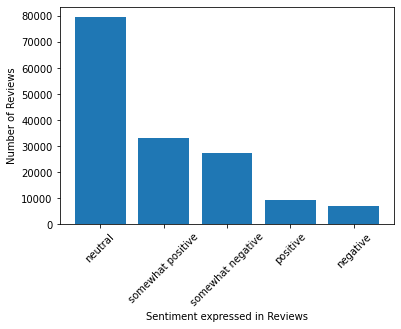

In [79]:
lstm.load_reviews(training_data_folder)

In [80]:
lstm.load_glove(glove_folder)

Loading GloVe embeddings...
400000 embeddings loaded.


In [81]:
model = lstm.fit(model_name='sentiments_100neurons', folder='./models/sentiments')

Balancing dataset...
Using 7072 samples per category
Building training and test datasets...
Building word embeddings from GloVe...
Building model...
Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_4 (Embedding)      (None, 100, 300)          18000000  
_________________________________________________________________
lstm_4 (LSTM)                (None, 100)               160400    
_________________________________________________________________
dropout_4 (Dropout)          (None, 100)               0         
_________________________________________________________________
dense_4 (Dense)              (None, 5)                 505       
Total params: 18,160,905
Trainable params: 160,905
Non-trainable params: 18,000,000
_________________________________________________________________
None
Fitting model...
Epoch 1/50
221/221 [==============================] - ETA: 0s -

ValueError: ignored

In [82]:
lstm.make_prediction('i will never go there again, food was awful')

'negative'

In [84]:
lstm.make_prediction('food is amazing and service is good')

'positive'

In [85]:
lstm.make_prediction('well, i am not sure, food was ok, but service was good')

'negative'

In [94]:
lstm.make_prediction("A series")

'neutral'

In [88]:
lstm.make_prediction("Kidman is really the only thing that 's worth watching in Birthday Girl , a film by the stage-trained Jez Butterworth -LRB- Mojo -RRB- that serves as yet another example of the sad decline of British comedies in the post-Full Monty world .")

'somewhat positive'

In [89]:
lstm.make_prediction('watching in Birthday Girl , a film by the stage-trained Jez Butterworth -LRB- Mojo -RRB- that serves')

'somewhat negative'

In [91]:
lstm.make_prediction('yet another example of the sad decline of British comedies')

'somewhat positive'

In [92]:
lstm.make_prediction('I kept wishing I was watching a documentary about the wartime Navajos and what they accomplished instead of all this specious Hollywood hoo-ha .')

'positive'

In [95]:
dfTest = pd.read_csv("/content/drive/My Drive/Colab Notebooks/RNN/test.tsv", sep="\t")

In [96]:
dfTest.head()

,PhraseId,SentenceId,Phrase
0,156061,8545,An intermittently pleasing but mostly routine ...
1,156062,8545,An intermittently pleasing but mostly routine ...
2,156063,8545,An
3,156064,8545,intermittently pleasing but mostly routine effort
4,156065,8545,intermittently pleasing but mostly routine


In [ ]:
dfTest['Sentiment'] = dfTest['Phrase'].apply(lstm.make_prediction)

In [ ]:
dfTest.head(50)